# Markov Drip Process

## Initial setup

In [117]:
import numpy as np
import math
import matplotlib.pyplot as plt

## Poisson distribution

### Create handling class

In [119]:
class Poisson:
    
    def __init__(self, lam):
        self.lam = lam
        
    def cdf(self, t):
        return 1.0 - np.exp(-self.lam*t)
    
    def inv_cdf(self, F):
        return -(1.0/self.lam)*np.log(1.0 - F)
        
    def times(self, n=1, t_max=np.inf):
        """Returns inter-event interval times sampled from Poisson distribution."""
        F = np.random.uniform(size=n)
        t = self.inv_cdf(F)
        t[t > t_max] = t_max
        return t
    
    def events(self, s):
        """Returns number of events N(s) in interval [0, s) sampled from Poisson distribution."""
        # Guess number of events as Poisson mean
        mean = self.lam*s
        chunk = max(int(mean), 1)
        T = np.cumsum(self.times(chunk))
        idx = np.searchsorted(T, s, side='left')
        n = idx
        
        # Continue sampling time until time s reached
        while (idx == T.size):
            T = np.cumsum(self.times(chunk)) + T[-1]
            idx = np.searchsorted(T, s, side='left')
            n += idx
        
        return n
    
    def P(self, n, s):
        """Returns probability of N(s) = n""" 
        return np.exp(-self.lam*s)*(np.power(self.lam*s, n))/self._factorial(n)
    
    def _factorial(self, n):
        if isinstance(n, np.ndarray):
            fact = np.zeros(n.size)
            for i, n_i in enumerate(n):
                fact[i] = np.prod(np.arange(max(n_i, 1))+1)
        else:
            fact = np.prod(np.arange(max(n_i, 1))+1)
    
        return fact

### Test inter-event time sampling
This should be drawn from an exponential distribution: $t \sim \lambda e^{-\lambda t}$

Expected mean: 2.00000e+00
Actual mean: 2.03639e+00
Expected std: 2.00000e+00
Actual std: 2.03890e+00


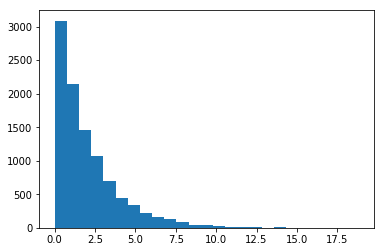

In [107]:
# Settings
lam = 0.5
poisson = Poisson(lam)

# Get inter-event times
sample = poisson.times(10000)

# Print results
print('Expected mean: %.5e' % (1.0/lam))
print('Actual mean: %.5e' % (np.mean(sample)))
print('Expected std: %.5e' % (1.0/lam))
print('Actual std: %.5e' % (np.std(sample)))

# Plot results
plt.hist(sample, bins=25);

### Test event sampling
This should be drawn from the Poisson distribution: $N(s) \sim Poisson(\lambda s)$

Expected mean: 10.00000
Actual mean: 10.15500
Expected std: 3.16228
Actual std: 3.09338


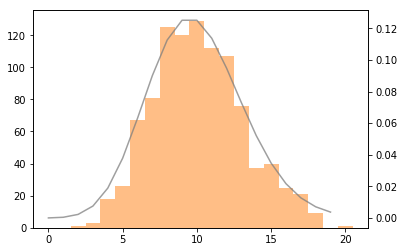

In [110]:
# Settings
lam = 2.0
s = 5.0
iters = 1000

# Create distribution
poisson = Poisson(lam)

# Sample number of events
sample = np.zeros(iters, dtype=np.int64)
for i in range(iters):
    sample[i] = poisson.events(s)
    
# Get probabilities of events samples
n_range = np.arange(2*lam*s)
probs = poisson.P(n=n_range, s=s)

# Print results
print('Expected mean: %.5f' % (lam*s))
print('Actual mean: %.5f' % (np.mean(sample)))
print('Expected std: %.5f' % ((lam*s)**0.5))
print('Actual std: %.5f' % (np.std(sample)))

# Plot results
fig, ax = plt.subplots()
ax.hist(sample, bins=np.arange(np.max(sample))+0.5, color='C1', alpha=0.5)
ax2 = ax.twinx()
ax2.plot(n_range, probs, color='C7', alpha=0.75);

## Patch modeling

### Model single patch

In [124]:
# Settings
lam_0 = 1.0 # initial Poisson rate
tau = 30.0 # rate of decay of lambda
V_drip = 2.0 # drip volume (uL)
V_reward = 2.0 # reward volume (uL)
num_events = 100 # number of iterations
t = 0 # current time (s)

# Create initial distribution
lam = lam_0
mouse = Poisson(1.0/5.0)
drip = Poisson(lam_0)
bucket = 0.0 # volume in bucket

# Placeholders (for debugging)
t_drip = [] # drip times
t_lick = [] # lick times
t_event = np.zeros(num_events)
V_bucket = np.zeros(num_events) # bucket volume

t, t_next_drip, t_next_lick = 0, 0, 0
for i in range(num_events):
    # Increment timer to next event
    t = min(t_next_drip, t_next_lick)
    
    # Update Poisson params
    drip.lam = lam_0 * np.exp(-t/tau)
    
    # Handle drip event
    if (t == t_next_drip):
        bucket += V_drip
        t_drip.append(t)
        t_next_drip = t + drip.times(t_max=100.0)
    
    # Handle lick event
    if (t == t_next_lick):
        if (bucket >= V_reward):
            bucket -= V_reward
        t_lick.append(t)
        t_next_lick = t + mouse.times(t_max=100.0)
        
    # Log bucket volume
    t_event[i] = t
    V_bucket[i] = bucket
    
# Create arrays
t_drip = np.array(t_drip)
t_lick = np.array(t_lick)

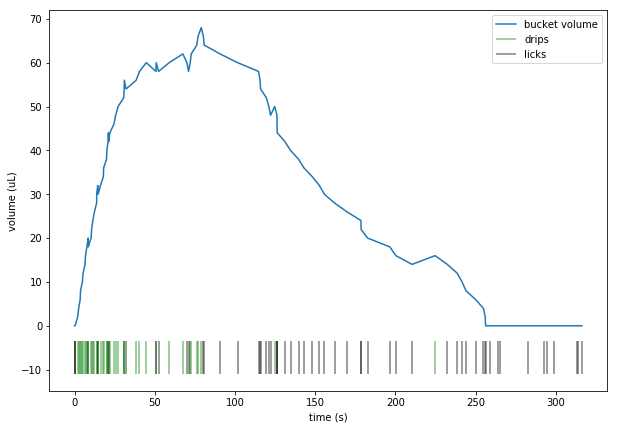

In [131]:
# Plot results
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(t_event, V_bucket, label='bucket volume')
ymin = ax.get_ylim()[0] - 0.1*np.diff(ax.get_ylim())
ymax = ax.get_ylim()[0]
ax.vlines(t_drip, ymin=ymin, ymax=ymax, color='green', alpha=0.5, label='drips')
ax.vlines(t_lick, ymin=ymin, ymax=ymax, color='black', alpha=0.5, label='licks')
ax.set_xlabel('time (s)')
ax.set_ylabel('volume (uL)')
ax.legend();

### Search parameter space

In [ ]:
_